In [6]:
import os
import json
import pandas as pd
import ast
import random
from openai import OpenAI
from tqdm import tqdm
import time
import matplotlib.pyplot as plt
import seaborn as sns
from dotenv import load_dotenv

load_dotenv()

# 定义所需的环境变量
REQUIRED_VARS = [
    "OPENROUTER_API_KEY",
    "OPENROUTER_BASE_URL",
]

# 使用字典推导式加载配置，同时检查缺失项
config = {var: os.environ.get(var) for var in REQUIRED_VARS}
missing_vars = [var for var, value in config.items() if not value]

if missing_vars:
    raise ValueError(f"错误: 缺少必要的环境变量: {', '.join(missing_vars)}")

In [7]:
client = OpenAI(
    api_key=config["OPENROUTER_API_KEY"], 
    base_url=config["OPENROUTER_BASE_URL"]
    )

In [8]:
# --- Model Selection ---
# The model we are testing for its correction ability
PLANNER_MODEL = "google/gemini-2.5-flash"
# The model acting as the objective evaluator
JUDGE_MODEL = "google/gemini-2.5-pro"

# --- Files and Samples ---
INPUT_FILE = "experiment_3_test_dataset.csv" # Using the dataset we created in Exp3
OUTPUT_DETAILED_RESULTS_FILE = "experiment_4_correction_results.csv"
OUTPUT_CHART_CORRECTION_RATE = "figure_7_correction_success_rate.png"
OUTPUT_CHART_FACTUALITY = "figure_8_answer_factuality_distribution.png"
NUM_CONFLICT_SAMPLES = 20 # Number of conflict scenarios to test

# --- Prompt Templates ---
# The prompt for the Planner to generate the final answer under conflict
PLANNER_PROMPT = """
You are an intelligent and objective Q&A robot. Your task is to synthesize all available information to answer the user's question.
You MUST prioritize the "Verified External Evidence" over your own "Initial Hypothesis" if they conflict. Your final answer should be concise and directly address the original question.

Original Question: "{question}"

Your Initial Hypothesis (potentially incorrect): {incorrect_hypothesis}

Verified External Evidence:
---
{correct_evidence}
---

Based on all the above, please provide the final, evidence-based answer to the Original Question.
"""

# The prompt for the Judge to evaluate the Planner's answer
JUDGE_PROMPT = """
You are a meticulous AI evaluator. Your task is to judge an answer generated by another AI based on the provided evidence.

**Context:**
- Original Question: "{question}"
- Ground Truth Evidence Snippets:
---
{evidence}
---

**Generated Answer to Evaluate:**
"{answer}"

**Evaluation Tasks:**
1.  **Correction Check**: The AI was given an incorrect initial hypothesis but was also given the correct evidence above. Did the "Generated Answer" correctly ignore the wrong hypothesis and base its conclusion *only* on the "Ground Truth Evidence Snippets"?
2.  **Factuality Check**: Is every factual claim made in the "Generated Answer" directly supported by the "Ground Truth Evidence Snippets"? The answer should not invent new facts.

**Your Output:**
You MUST respond in a valid JSON format with three keys:
- "correction_successful": A boolean (true or false). True if the answer aligns with the evidence.
- "factuality_score": A float between 0.0 (completely unsupported) and 1.0 (fully supported by the evidence).
- "reasoning": A brief explanation for your scores.
"""

In [9]:
def call_llm(prompt, model, is_json=False):
    """Generic wrapper for LLM calls with basic retry."""
    for _ in range(2): # Retry once
        try:
            response = client.chat.completions.create(
                model=model,
                messages=[{"role": "user", "content": prompt}],
                temperature=0.0,
                response_format={"type": "json_object"} if is_json else None
            )
            return response.choices[0].message.content.strip()
        except Exception as e:
            print(f"LLM call to {model} failed, retrying... Error: {e}")
            time.sleep(1)
    return None


def prepare_conflict_dataset():
    """Prepares conflict scenarios from the Exp3 dataset."""
    print("--- Step 1: Preparing Conflict Scenarios Dataset ---")
    try:
        df_exp3 = pd.read_csv(INPUT_FILE)
    except FileNotFoundError:
        print(f"Error: Input file '{INPUT_FILE}' not found. Please run Experiment 3 first.")
        return None

    # We need the original question, which is not in the Exp3 dataset.
    # We will assume a placeholder or reconstruct it. For this script, let's
    # find the original question from the Exp1 dataset by matching the triple.
    # This is complex, so we'll simplify: we'll use the triple itself to form a question.
    
    supports_df = df_exp3[df_exp3['golden_label'] == 'Supports'].head(NUM_CONFLICT_SAMPLES)
    if len(supports_df) < NUM_CONFLICT_SAMPLES:
        print(f"Warning: Only found {len(supports_df)} 'Supports' samples to create conflicts from.")

    conflict_scenarios = []
    refutes_prompt = """
    Given a true knowledge triple, create a plausible but false version of it by changing only the object.
    Original True Triple: {triple}
    Your task is to respond in JSON format with a single key "false_triple".
    Example: {{"false_triple": ["TSMC", "headquartered_in", "Shanghai"]}}
    """
    
    for _, row in tqdm(supports_df.iterrows(), total=len(supports_df), desc="Generating Conflicts"):
        true_triple_str = row['triple']
        evidence = row['snippets']
        
        # Formulate a simple question from the true triple's subject and predicate
        true_triple_list = ast.literal_eval(true_triple_str)
        question = f"What is the {true_triple_list[1]} of {true_triple_list[0]}?"
        
        # Generate a false triple to act as the incorrect hypothesis
        res = call_llm(refutes_prompt.format(triple=true_triple_str), JUDGE_MODEL, is_json=True)
        time.sleep(0.5)
        if res:
            try:
                false_triple_list = json.loads(res).get("false_triple")
                if false_triple_list:
                    conflict_scenarios.append({
                        "question": question,
                        "incorrect_hypothesis": str(false_triple_list),
                        "correct_evidence": evidence
                    })
            except Exception as e:
                print(f"Failed to process false triple generation: {e}")

    return pd.DataFrame(conflict_scenarios)


def run_correction_test(conflict_df: pd.DataFrame):
    """Runs the Planner and Judge on the conflict scenarios."""
    print(f"\n--- Step 2: Running Correction Test on {len(conflict_df)} scenarios ---")
    results = []
    for _, row in tqdm(conflict_df.iterrows(), total=len(conflict_df)):
        # 1. Planner generates an answer based on conflicting info
        planner_prompt = PLANNER_PROMPT.format(
            question=row['question'],
            incorrect_hypothesis=row['incorrect_hypothesis'],
            correct_evidence=row['correct_evidence']
        )
        generated_answer = call_llm(planner_prompt, PLANNER_MODEL)
        time.sleep(1)

        if not generated_answer:
            evaluation = {"correction_successful": False, "factuality_score": 0.0, "reasoning": "Planner failed to generate an answer."}
        else:
            # 2. Judge evaluates the Planner's answer
            judge_prompt = JUDGE_PROMPT.format(
                question=row['question'],
                evidence=row['correct_evidence'],
                answer=generated_answer
            )
            eval_res = call_llm(judge_prompt, JUDGE_MODEL, is_json=True)
            time.sleep(1)
            try:
                evaluation = json.loads(eval_res)
            except Exception:
                evaluation = {"correction_successful": False, "factuality_score": 0.0, "reasoning": "Judge failed to return valid JSON."}

        row_result = row.to_dict()
        row_result['generated_answer'] = generated_answer
        row_result.update(evaluation)
        results.append(row_result)

    return pd.DataFrame(results)


def analyze_and_visualize(final_df: pd.DataFrame):
    """Calculates final metrics and visualizes them."""
    print("\n--- Step 3: Analyzing Final Results ---")
    if final_df.empty:
        print("No results to analyze.")
        return

    # 1. Correction Success Rate
    correction_rate = final_df['correction_successful'].mean()
    print(f"Correction Success Rate: {correction_rate:.2%}")
    
    plt.figure(figsize=(8, 6))
    sns.set_theme(style="whitegrid")
    bar = sns.barplot(x=["Correction Success Rate"], y=[correction_rate], palette=["mediumseagreen"])
    plt.axhline(y=0.80, color='r', linestyle='--', label='Success Threshold (80%)')
    plt.title('Experiment 4: Correction Success Rate', fontsize=16)
    plt.ylabel('Success Rate')
    plt.ylim(0, 1.05)
    plt.text(0, correction_rate, f'{correction_rate:.2%}', ha='center', va='bottom', fontsize=14)
    plt.legend()
    plt.tight_layout()
    plt.savefig(OUTPUT_CHART_CORRECTION_RATE)
    print(f"Correction rate chart saved to {OUTPUT_CHART_CORRECTION_RATE}")

    # 2. Answer Factuality Distribution
    avg_factuality = final_df['factuality_score'].mean()
    print(f"Average Answer Factuality Score: {avg_factuality:.2f}")

    plt.figure(figsize=(10, 6))
    sns.histplot(final_df['factuality_score'], bins=10, kde=True, color="dodgerblue")
    plt.title('Distribution of Answer Factuality Scores', fontsize=16)
    plt.xlabel('Factuality Score (1.0 = Fully Supported by Evidence)')
    plt.ylabel('Number of Answers')
    plt.xlim(0, 1)
    plt.tight_layout()
    plt.savefig(OUTPUT_CHART_FACTUALITY)
    print(f"Factuality distribution chart saved to {OUTPUT_CHART_FACTUALITY}")

In [10]:
def main():
    """Main function to run the entire experiment."""
    conflict_dataset = prepare_conflict_dataset()
    if conflict_dataset is not None and not conflict_dataset.empty:
        final_results = run_correction_test(conflict_dataset)
        final_results.to_csv(OUTPUT_DETAILED_RESULTS_FILE, index=False, encoding='utf-8-sig')
        print(f"\nDetailed results of the test saved to {OUTPUT_DETAILED_RESULTS_FILE}")
        analyze_and_visualize(final_results)

--- Step 1: Preparing Conflict Scenarios Dataset ---


Generating Conflicts: 100%|██████████| 20/20 [03:26<00:00, 10.33s/it]



--- Step 2: Running Correction Test on 20 scenarios ---


100%|██████████| 20/20 [04:01<00:00, 12.06s/it]
/tmp/ipykernel_115524/1324984657.py:121: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  bar = sns.barplot(x=["Correction Success Rate"], y=[correction_rate], palette=["mediumseagreen"])



Detailed results of the test saved to experiment_4_correction_results.csv

--- Step 3: Analyzing Final Results ---
Correction Success Rate: 95.00%
Correction rate chart saved to figure_7_correction_success_rate.png
Average Answer Factuality Score: 0.97
Factuality distribution chart saved to figure_8_answer_factuality_distribution.png


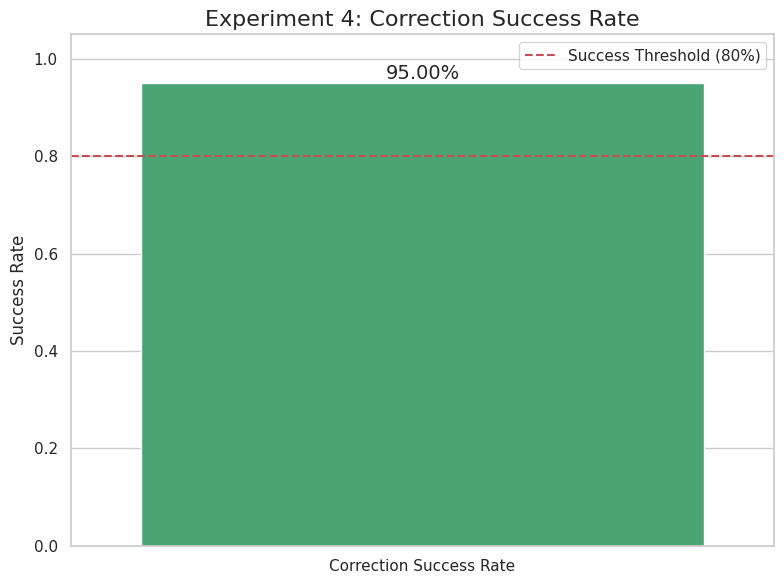

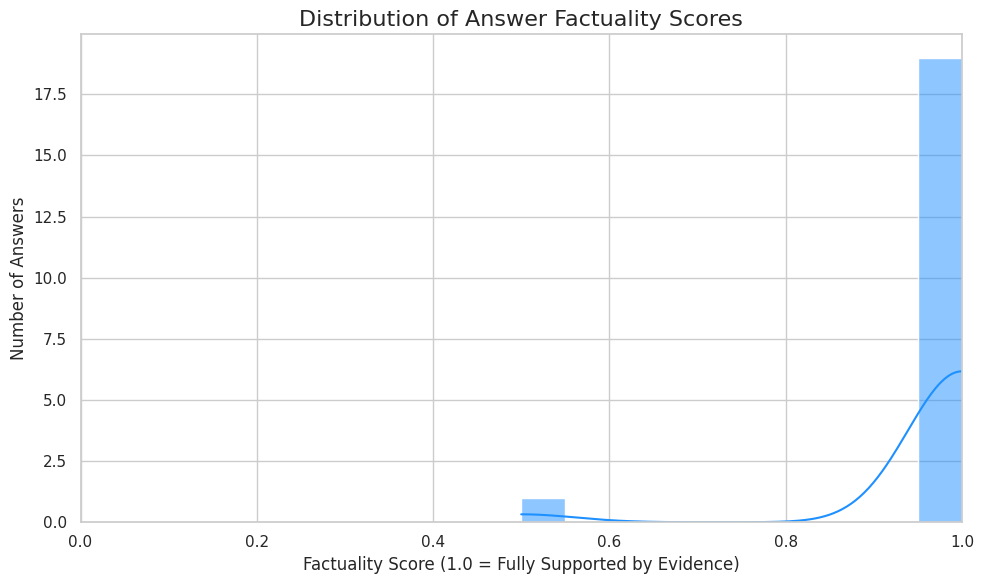

In [11]:
main()